In [1]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=d2c7716244c2c1489878d9d430084b7bbf6ccd97db014a3044c2ae6bf5c8b238
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15357 sha256=b3e47c5c3401efff0bfe26e2318f9ec2a8dea1e86817496cde6fa4ca15645407
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


COVID-19 detection

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding, Activation, AveragePooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.applications.inception_v3 import InceptionV3
from kerastuner.tuners import Hyperband
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model
from google.colab import files
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
import itertools
import os

In [3]:
import zipfile
# Download the dataset from google drive because from kaggle the download failed by error 404 
# Kaggle: https://www.kaggle.com/mohammadrahimzadeh/covidctset-a-large-covid19-ct-scans-dataset
# we have it downloaded, if it doesnt start, ask for help
!gdown --id 1N0jmtIJkzRrPJHpXpk8mlM5JPirL6_Gb --output /tmp/train_valid.zip
local_zip = '/tmp/train_valid.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/train_valid')
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1N0jmtIJkzRrPJHpXpk8mlM5JPirL6_Gb
To: /tmp/train_valid.zip
4.33GB [01:16, 56.7MB/s]


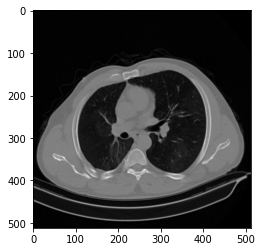

In [4]:
# show an image of the dataset
import matplotlib.pyplot as plt
path='/tmp/train_valid/137covid_patient100_SR_2_IM00029.tif'
img = plt.imread(path)
plt.imshow(img, cmap="gray")
plt.show()

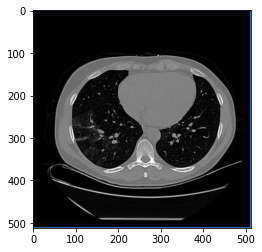

In [5]:
# showing the image we want to predict with the model
path = '/content/5TUDO.tif'
img = plt.imread(path)
plt.imshow(img, cmap="gray")
plt.show()

In [6]:
print(img.shape)

(512, 512, 3)


In [7]:
# get the filenames of the pictures
source = os.path.join("/tmp", "train_valid")
set_filenames = os.listdir(source)

In [8]:
# create 2 array, one with the covid pictures, one with the normals
covid_fnames = []
normal_fnames = []
for f in set_filenames:
  if "normal" in f:
    normal_fnames.append(f)
  else:
    covid_fnames.append(f)

In [9]:
# create the test, valid, train arrays
from random import shuffle
train_size = 1500
test_size = 391

shuffle(covid_fnames)
shuffle(normal_fnames)
train_X = covid_fnames[:train_size]
test_X = covid_fnames[train_size:train_size+test_size]
valid_X = covid_fnames[train_size+test_size:]
train_X.extend(normal_fnames[:train_size])
valid_X.extend(normal_fnames[train_size:train_size+test_size+10])
test_X.extend(normal_fnames[train_size+test_size+10:])

In [10]:
# create directories for the dataimagegenerator
train_covid = os.path.join("/tmp", "train/covid")
train_normal = os.path.join("/tmp", "train/normal")
valid_covid = os.path.join("/tmp", "valid/covid")
valid_normal = os.path.join("/tmp", "valid/normal")
test_covid = os.path.join("/tmp", "test/covid")
test_normal = os.path.join("/tmp", "test/normal")
source = os.path.join("/tmp", "train_valid")

import shutil
os.makedirs(train_covid)
os.makedirs(train_normal)
os.makedirs(valid_covid)
os.makedirs(valid_normal)
os.makedirs(test_covid)
os.makedirs(test_normal)

In [11]:
# moving the images to their directory
images = os.listdir(source)
for im in images:
  if  im in train_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), train_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), train_normal)
  elif im in valid_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), valid_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), valid_normal)
  elif im in test_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), test_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), test_normal)

In [12]:
#getting the train/test/valid directories
train_dir = os.path.join("/tmp/train")
test_dir = os.path.join("/tmp/test")
valid_dir = os.path.join("/tmp/valid")

In [13]:
# using batch size 32 and image size 299 for the images wit grayscale
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.05)
test_datagen = ImageDataGenerator(rescale=1./255)

#prepocessing images
train_generator = train_datagen.flow_from_directory(train_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary')#, color_mode='grayscale')
valid_generator = test_datagen.flow_from_directory(valid_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary')#, color_mode='grayscale')
test_generator = test_datagen.flow_from_directory(test_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary', shuffle=False)#, color_mode='grayscale')

Found 3000 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [14]:
# keras tuner will use this function to create the models to search for the best one
def build_model(hp):
  shape=(img_size,img_size,3)
  input_tensor=Input(shape=shape)

  # load in the base model InceptionV3
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=shape)
  # set the base model untrainable for transferlearning
  for layer in base_model.layers:
    layer.trainable = False

  # put the base_model as the input
  # and use the conv4_block1_preact_relu layer's output for the rest
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # add some Dense layers with min units 16, max units 128 with step 32
  # add dropout with value 0.1 to 0.4 by step 0.1
  x = Dense(units=hp.Int('dense_1_units', min_value=48, max_value=128, step=32),
            activation='relu')(x)
  x = Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.3, step=0.1))(x)
  x = Dense(units=hp.Int('dense_2_units', min_value=16, max_value=80, step=32),
            activation='relu')(x)
  x = Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.3, step=0.1))(x)
  # the output layer with 1 neuron with sigmoid activaton
  pred = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=pred)
  #compile the model with a categorical crossentropy
  model.compile(optimizer=Nadam(learning_rate=hp.Choice('learning_rate', values=[1e-5])),
                                loss="binary_crossentropy", metrics=['accuracy'])
  
  return model

In [15]:
# create the Hyperband tuner with the above funcition, looking for the best val_accuracy, with max 30 epoch
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    factor=3,
    max_epochs=30,
    directory='output',
    project_name='Inception_hyperbrand')

87916544/87910968 [==============================] - 0s 0us/step


In [16]:
import IPython
# class for clearing the output
class ClearTrainingOutput(callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [17]:
# train the models with the generators, using earlystopping and clearing outputs
tuner.search(train_generator, validation_data=valid_generator, callbacks=[callbacks.EarlyStopping('val_loss', patience=5), ClearTrainingOutput()])

Trial 52 Complete [00h 29m 05s]
val_accuracy: 0.8030303120613098

Best val_accuracy So Far: 0.8030303120613098
Total elapsed time: 04h 02m 44s
INFO:tensorflow:Oracle triggered exit


In [18]:
# get the best model of all
model = tuner.get_best_models(num_models=1)[0]
model.summary()

# save the best model
save_model(model, 'inception_weights.hdf5')

# download the weights of the model
files.download('inception_weights.hdf5') 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# set the upper layers of the model trainable
for layer in model.layers[172:]:
       layer.trainable = True

In [20]:
# compile the model with SGD and a small learning rate for fine tuning
model.compile(optimizer=SGD(learning_rate=0.0001,momentum=0.9),loss="binary_crossentropy",metrics=['accuracy'])

In [21]:
# early stopping to avoid overfitting
early_stopping=EarlyStopping(patience=10, verbose=1)
# save the weughts of the best model in weights.hdf5
checkpointer=ModelCheckpoint(filepath='inception_weights_fine_tuned.hdf5', save_best_only=True, verbose=1)

In [22]:
# fine tune the model
model.fit(train_generator,
          validation_data=valid_generator, 
          epochs=200, 
          steps_per_epoch=3000//batch_size, 
          validation_steps=792//batch_size, 
          callbacks=[early_stopping, checkpointer])

Epoch 1/200
93/93 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.7372
Epoch 00001: val_loss improved from inf to 0.46511, saving model to inception_weights_fine_tuned.hdf5
93/93 [==============================] - 90s 973ms/step - loss: 0.5448 - accuracy: 0.7372 - val_loss: 0.4651 - val_accuracy: 0.7812
Epoch 2/200
93/93 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8157
Epoch 00002: val_loss improved from 0.46511 to 0.41724, saving model to inception_weights_fine_tuned.hdf5
93/93 [==============================] - 90s 966ms/step - loss: 0.4474 - accuracy: 0.8157 - val_loss: 0.4172 - val_accuracy: 0.8203
Epoch 3/200
93/93 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8460
Epoch 00003: val_loss improved from 0.41724 to 0.38626, saving model to inception_weights_fine_tuned.hdf5
93/93 [==============================] - 90s 963ms/step - loss: 0.3777 - accuracy: 0.8460 - val_loss: 0.3863 - val_accuracy: 0.8385
Epoch

In [23]:
# download the best weights
files.download('inception_weights_fine_tuned.hdf5') 

#load in the best weights
model = load_model('inception_weights_fine_tuned.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# evaluate the model
model.evaluate(test_generator)

259/259 [==============================] - 104s 403ms/step - loss: 0.0998 - accuracy: 0.9675


[0.0998397022485733, 0.9674570560455322]

In [25]:
# function that prints and plots the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       covid       0.60      0.95      0.73       391
      normal       1.00      0.97      0.98      7875

    accuracy                           0.97      8266
   macro avg       0.80      0.96      0.86      8266
weighted avg       0.98      0.97      0.97      8266



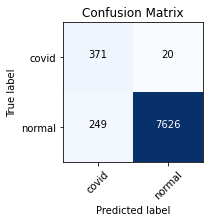

In [26]:
# Print the Target names
import numpy as np

target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

# Confusion Matrix 
Y_pred = model.predict(test_generator)
y_pred = Y_pred > 0.5
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [27]:
# predicate the two image we have with the model, and write the result
# load in the image
img = image.load_img('/content/13TUDO.tif',target_size=(299,299))

# create an array from it
img= image.img_to_array(img)
# normalization
img /= 255
img = np.expand_dims(img,axis=0)
preds = model.predict(img)
print(preds)

img = image.load_img('/content/5TUDO.tif',target_size=(299,299))

img= image.img_to_array(img)
img /= 255
img = np.expand_dims(img,axis=0)
preds = model.predict(img)
print(preds)

[[0.99192446]]
[[0.9599471]]
